In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature
# plot
import cmocean as ccm

In [2]:
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

In [3]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39643 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44871' processes=5 threads=10, memory=20.00 GiB>

In [4]:
chunk_size = {"x":500,"y":500}

dataGAI = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/wind_curl/eORCA025.L75-IMHOTEP.GAI_y1980-2018_1y_curl.nc', chunks=chunk_size ).squeeze()
curlAI  = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/wind_curl/eORCA025.L75-IMHOTEP.AI_y1980-2018_1y_curl.nc', chunks=chunk_size).squeeze().socurl
curlS   = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/wind_curl/eORCA025.L75-IMHOTEP.S_y1980-2018_1y_curl.nc', chunks=chunk_size,).squeeze().socurl
curlGAI = dataGAI.socurl

In [5]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc', chunks={"x":500,"y":500}).BGRmask.squeeze()

In [6]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc',chunks=chunk_size).squeeze()
fmask = mesh_hgr.fmask
e1 = mesh_hgr.e1f.fillna(0)
e2 = mesh_hgr.e2f.fillna(0)
bt = (e1 * e2).load()

btboxBG = bt.where(maskBG,drop=True)
tmaskboxBG = fmask.where(maskBG,drop=True)
oceanArea = (btboxBG*tmaskboxBG[0])  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
WeightboxBG = (oceanArea/totalOceanArea) #.compute()

In [7]:
#========= Plot settings ===============
nav_lon =  dataGAI.nav_lon.mean('time_counter')
nav_lat =  dataGAI.nav_lat.mean('time_counter')

# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = cm.RdYlBu_r #Spectral_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

lmin = -5e-7
incr = 5e-8
lmax = lmin*(-1)+incr
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)


# map for comparison with the curl calculated with python

In [14]:
curlGAImean = curlGAI.mean('time_counter')

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


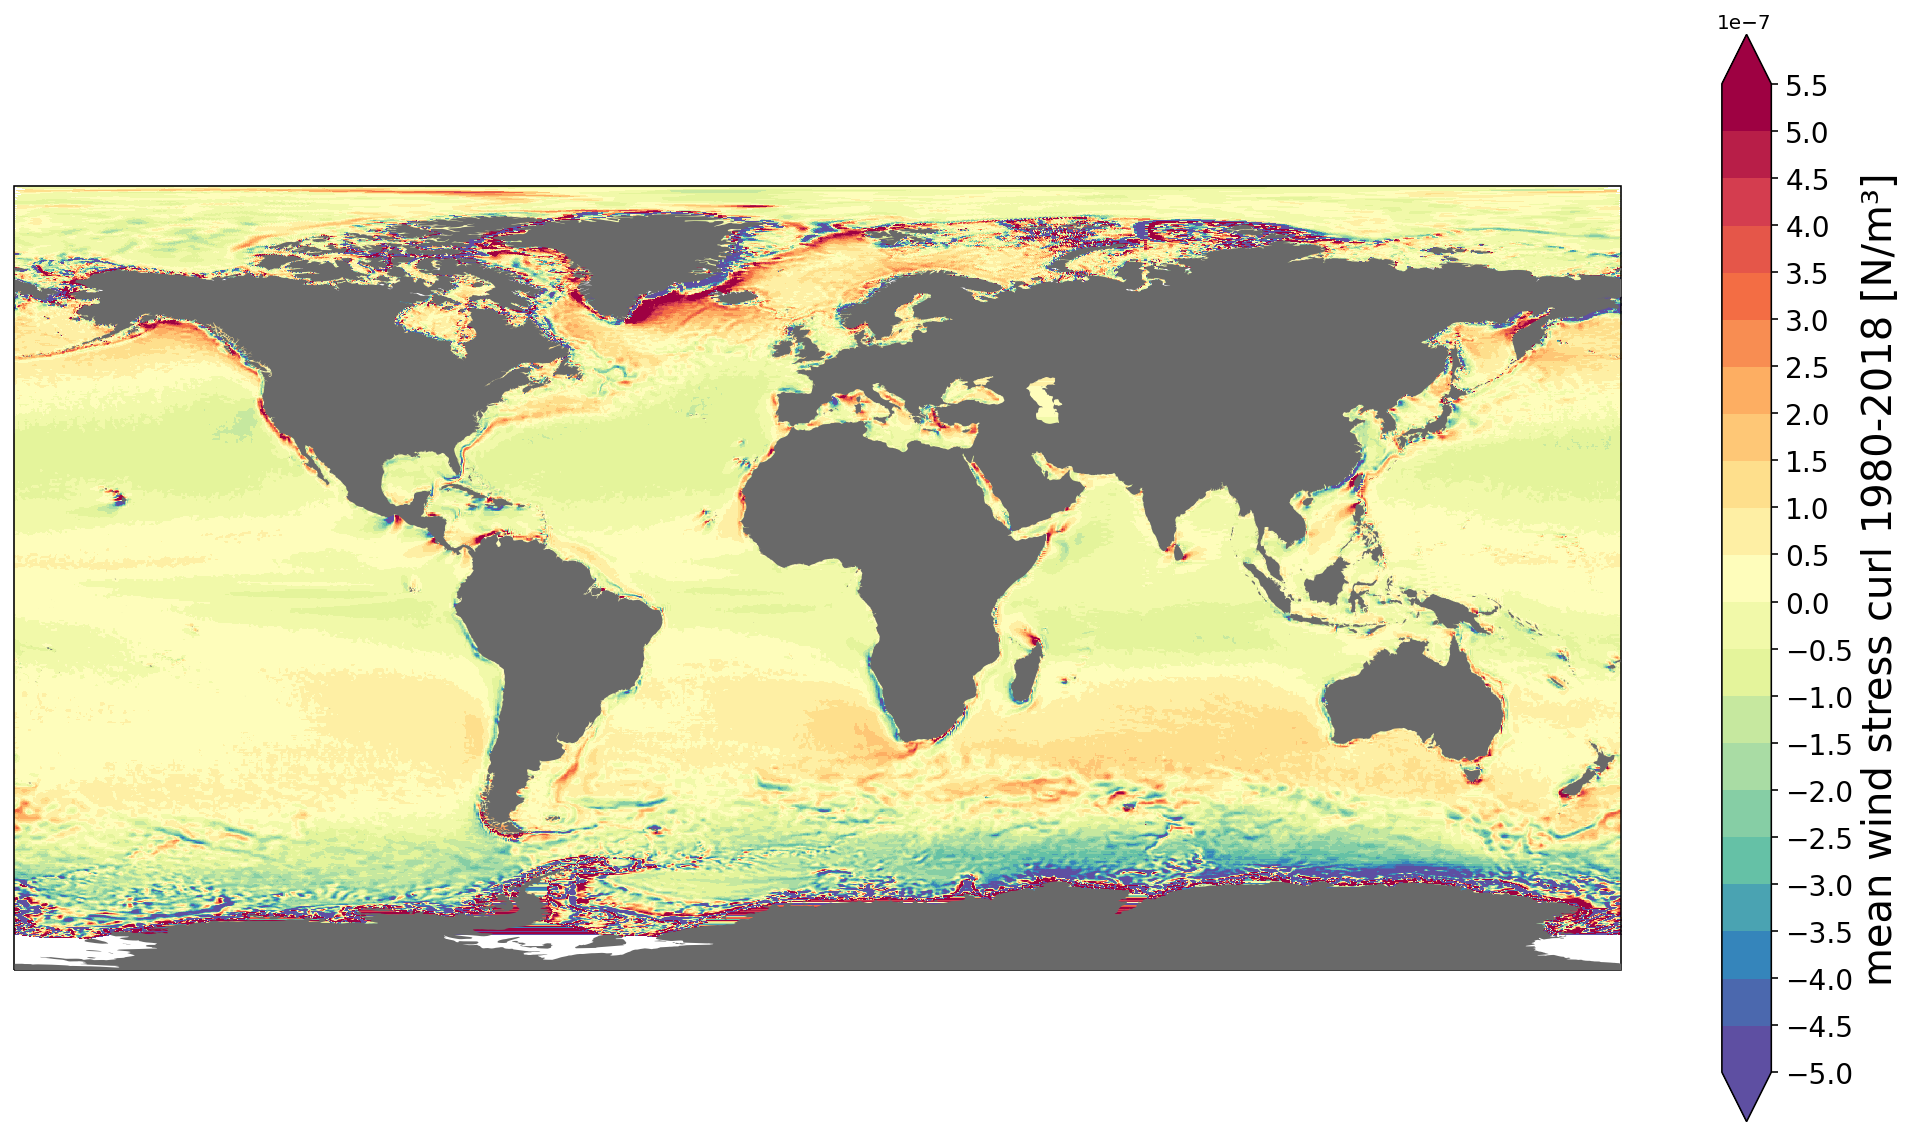

<Figure size 432x288 with 0 Axes>

In [20]:
#========= Plot settings ===============
nav_lon =  dataGAI.nav_lon.mean('time_counter')
nav_lat =  dataGAI.nav_lat.mean('time_counter')

# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = cm.Spectral_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

lmin = -5e-7
incr = 5e-8
lmax = lmin*(-1)+incr
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)

#========= CREATE FIGURE
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# RUN to PLOT
# data2plot = r_matrix2plot.isel(lag=i).where(tmask!=0,0).squeeze()
# yr, mm = dates(S_GR_short.isel(time_counter=t))
# tlabel= "Correlation coefficient for time lag = "+str(r_matrix2plot.lag[i].values)+" years" #"whole column S_GR integral for "+str(yr)+"-"+f"{mm:02d}" + r" [10$-3$]"
# namo  ="GAI_AI_corr_map_SSH_S_GR_lag"+str(r_matrix2plot.lag[i].values)+"y.png"
# print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.PlateCarree())

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, curlGAImean, shading='flat',cmap = mycm,transform=trdata, norm=norm)
cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'mean wind stress curl 1980-2018 [N/m³]', fontsize=20)

#========= coastlines and gridlines
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
# gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
# label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
# gl.xlabel_style = label_style; gl.ylabel_style = label_style


# plt.title(tlabel,fontsize=24)
plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
# plt.close(fig)
plt.clf()

# Map in the Arctic for comparison with the data in the litterature

In [21]:
y1= "2005"
y2= "2017"
curlGAImean = curlGAI.sel(time_counter=slice(y1,y2)).mean('time_counter')

wind_stress_curl_cdftools_2005-2017.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


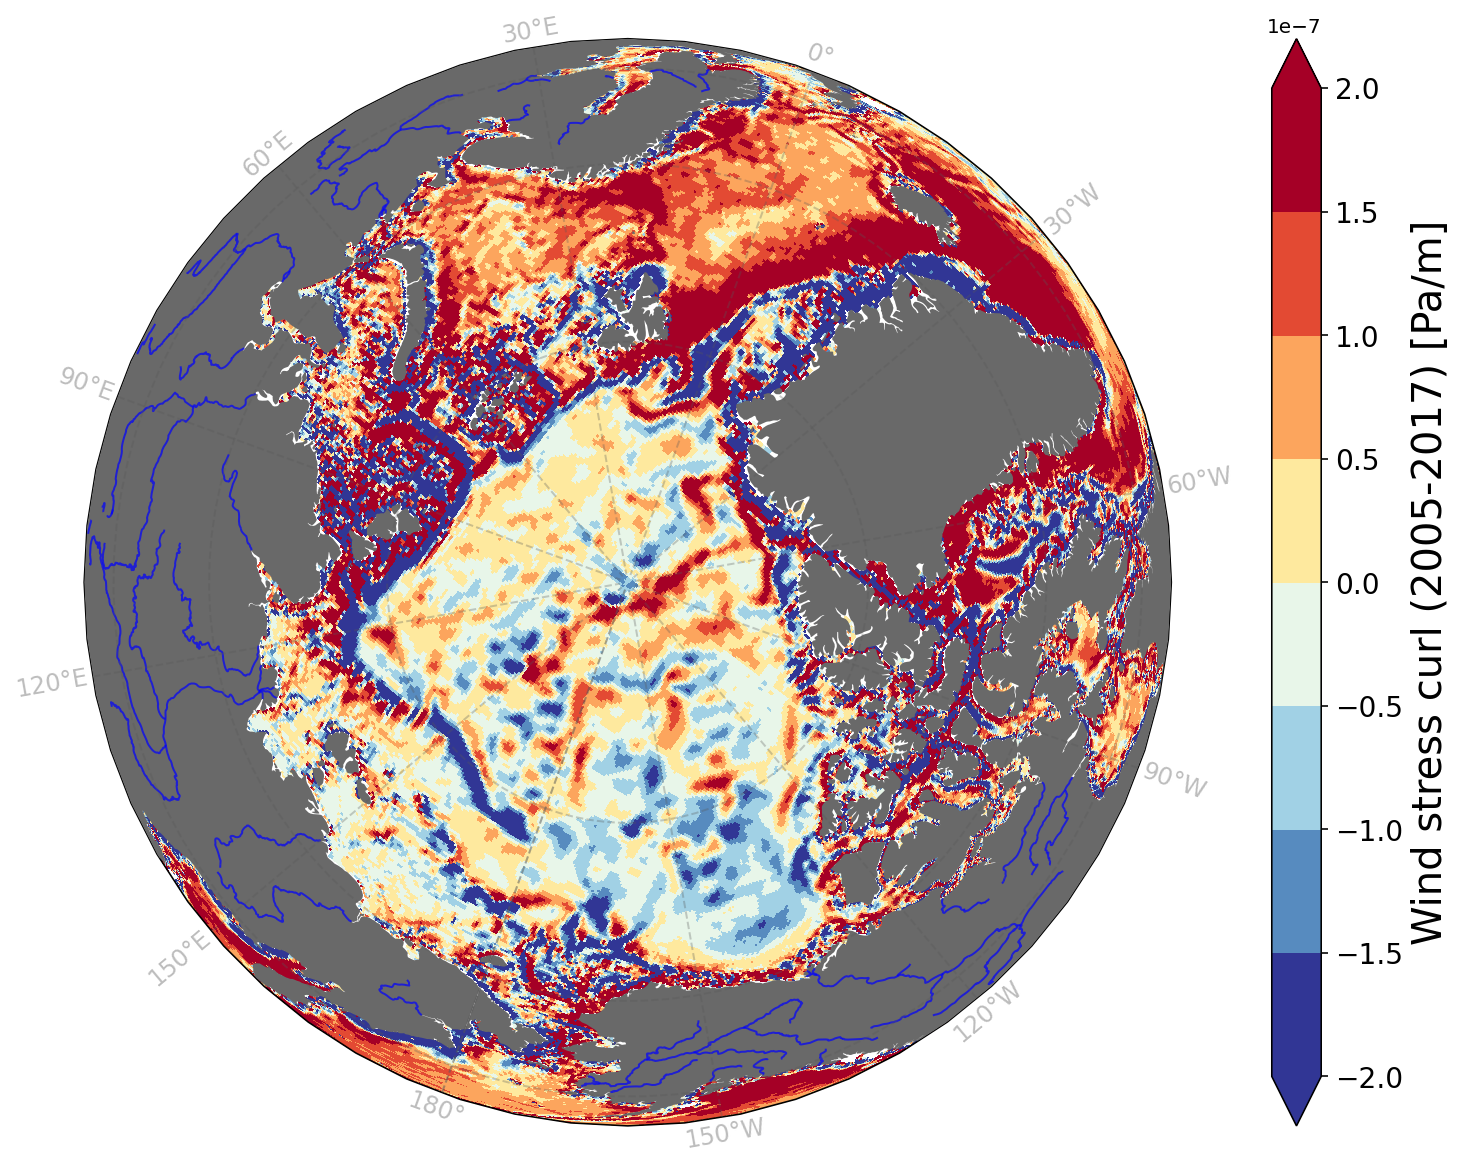

In [22]:
#========= Plot settings ===============
nav_lon =  dataGAI.nav_lon.mean('time_counter')
nav_lat =  dataGAI.nav_lat.mean('time_counter')

# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70
#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831

#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

lmin = -2e-7
incr = 5e-8
lmax = lmin*(-1)+incr
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)



diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# tlabel=" SSH trend of GREENLAND (mm/yr) over "+y1+"-"+y2
# namo  ="SSH_trendGAIAI_"+y1+"-"+y2+".png"
namo  ="wind_stress_curl_cdftools_"+y1+"-"+y2+".png"

print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, curlGAImean,shading='flat',cmap = mycm,transform=trdata, norm=norm)
cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Wind stress curl ("+y1+"-"+y2+") [Pa/m]", fontsize=20)

# cs2  = plt.pcolormesh(nav_lon, nav_lat, m2plt, shading='flat',transform=trdata) 
#========= coastlines and gridlines
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
clr2 = ax.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
gl.xlabel_style = label_style; gl.ylabel_style = label_style


# #============= BATHYMETRY
# bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
# color_levels= ['k','navy','mediumblue','slateblue']
# # west
# Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
# # east
# Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# plt.title(tlabel,fontsize=24)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)
# plt.clf()

# Analyse du wind stress curl de GAI

## carte de comparaisons 1980-2004 et 2005-2018

In [51]:
y1= "1980"
y2= "2004"
# y1= "2005"
# y2= "2018"

curlGAImean = curlGAI.sel(time_counter=slice(y1,y2)).mean('time_counter')

In [83]:
#========= Plot settings ===============
nav_lon =  dataGAI.nav_lon.mean('time_counter')
nav_lat =  dataGAI.nav_lat.mean('time_counter')

# default gridlines parameters
gridl=False
incrgridlon=30
incrgridlat=10

# vue N.Atl
# loncentr=330 # before it was zero
# latcentr=70
#vue polaire
loncentr=200 # before it was zero
latcentr=90

sath=2085831

#========= Plot settings ===============
# colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = cm.RdYlBu_r
my_map1 = truncate_colormap(cmap)
colors = my_map1(np.linspace(0., 1, 50))
mycm = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

wind_stress_curl_cdftools_1980-2004.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


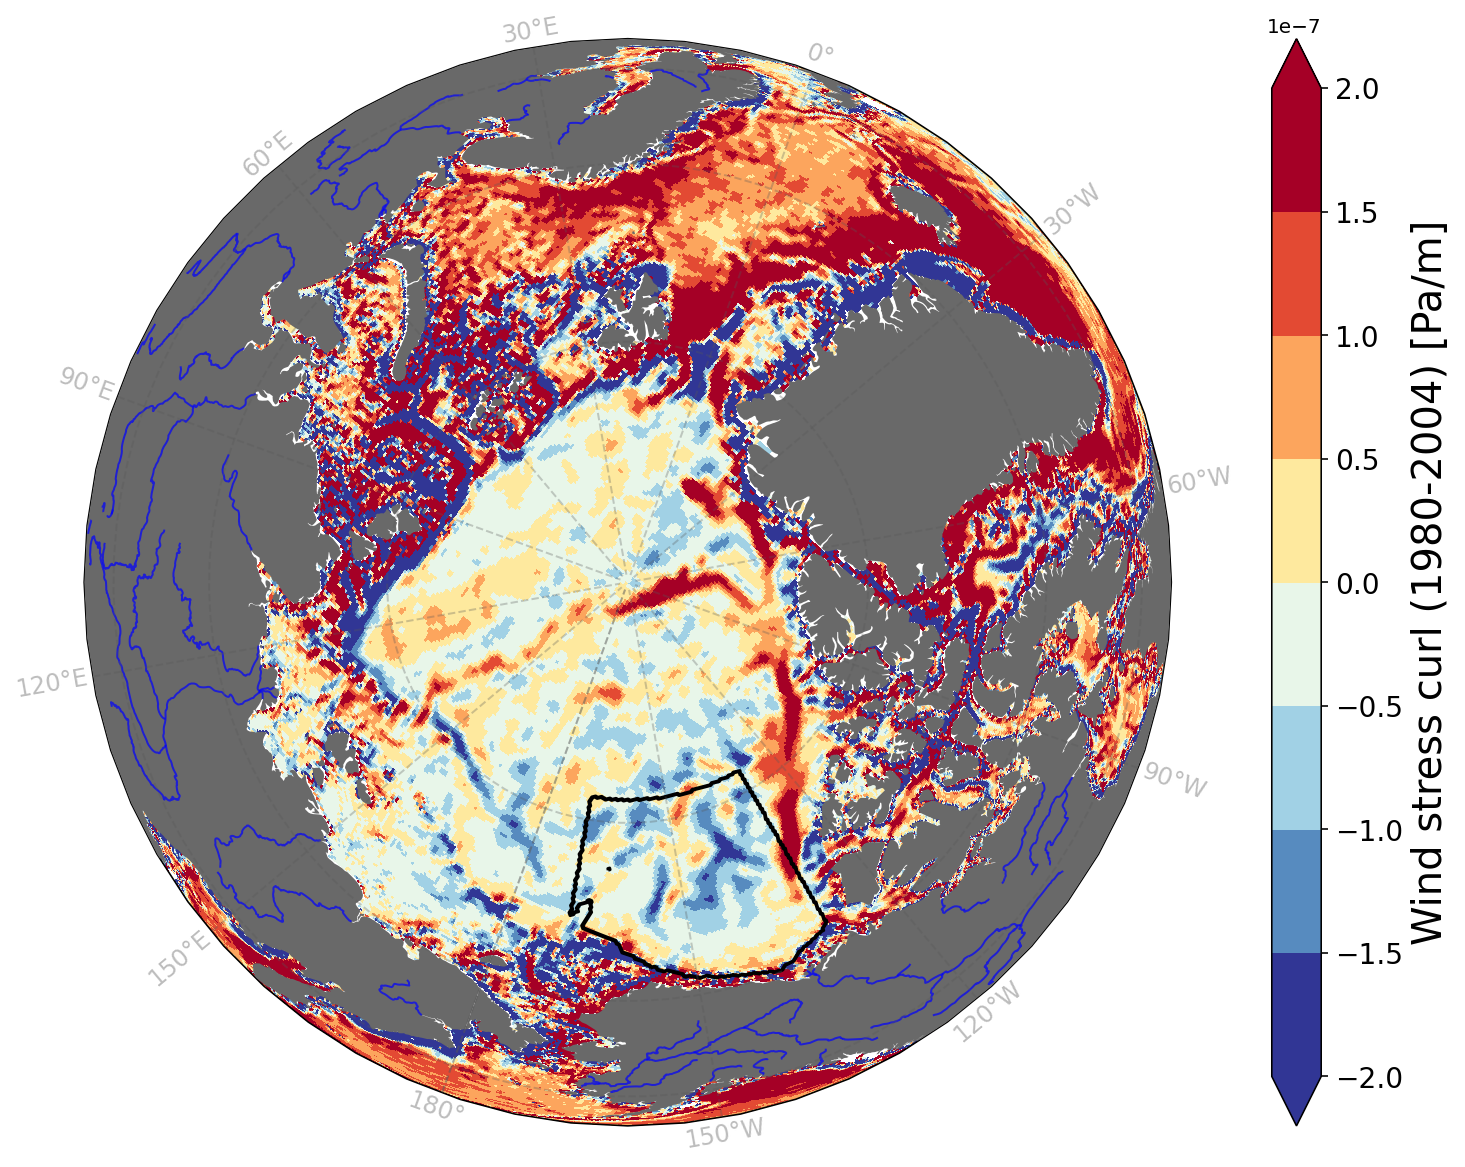

In [53]:

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# tlabel=" SSH trend of GREENLAND (mm/yr) over "+y1+"-"+y2
# namo  ="SSH_trendGAIAI_"+y1+"-"+y2+".png"
namo  ="wind_stress_curl_cdftools_"+y1+"-"+y2+".png"

print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, curlGAImean,shading='flat',cmap = mycm,transform=trdata, norm=norm)
ax.contour(nav_lon,nav_lat,maskBG,1,colors="k",transform=trdata)

cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Wind stress curl ("+y1+"-"+y2+") [Pa/m]", fontsize=20)

# cs2  = plt.pcolormesh(nav_lon, nav_lat, m2plt, shading='flat',transform=trdata) 
#========= coastlines and gridlines
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
clr2 = ax.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
gl.xlabel_style = label_style; gl.ylabel_style = label_style


# #============= BATHYMETRY
# bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
# color_levels= ['k','navy','mediumblue','slateblue']
# # west
# Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
# # east
# Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# plt.title(tlabel,fontsize=24)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)
# plt.clf()

## time series dans la BGR box

In [8]:
maskBGcurlGAI = curlGAI.where(maskBG,drop=True)
maskBGcurlAI = curlAI.where(maskBG,drop=True)
maskBGcurlS = curlS.where(maskBG,drop=True)


In [9]:
maskBGcurlGAImean =  (maskBGcurlGAI * WeightboxBG).sum(('x','y'))
maskBGcurlAImean  =  (maskBGcurlAI * WeightboxBG).sum(('x','y'))
maskBGcurlSmean   =  (maskBGcurlS * WeightboxBG).sum(('x','y'))

In [10]:
maskBGcurlGAI_Smean  = maskBGcurlGAImean - maskBGcurlSmean
maskBGcurlGAI_AImean = maskBGcurlGAImean - maskBGcurlAImean
maskBGcurlAI_Smean   = maskBGcurlAImean - maskBGcurlSmean

In [33]:
# quantification

print('MIN')
print( (maskBGcurlGAImean).min().values )
print( (maskBGcurlAImean).min().values )
print( (maskBGcurlSmean).min().values )

print('MAX')

print( (maskBGcurlGAImean).max().values )
print( (maskBGcurlAImean).max().values )
print( (maskBGcurlSmean).max().values )

print('MEAN')

print( (maskBGcurlGAImean).mean().values )
print( (maskBGcurlAImean).mean().values )
print( (maskBGcurlSmean).mean().values )

print('STD')

print( (maskBGcurlGAImean).std().values )
print( (maskBGcurlAImean).std().values )
print( (maskBGcurlSmean).std().values )


MIN
-1.1515494502925248e-07
-1.107264348343113e-07
-1.1397518365133971e-07
MAX
9.969417481677239e-09
1.0385003900396484e-08
1.0611775901256228e-08
MEAN
-3.3925193885921063e-08
-3.2918340148263396e-08
-3.421633720339477e-08
STD
2.1886060964236487e-08
2.1238487463969392e-08
2.172337220647864e-08


In [13]:
# STD
print(((maskBGcurlGAI_Smean).std().values / (maskBGcurlSmean).std().values )*100)
print(((maskBGcurlGAI_AImean).std().values / (maskBGcurlAImean).std().values )*100)
print(((maskBGcurlAI_Smean).std().values / (maskBGcurlSmean).std().values )*100)


6.196656837369241
9.688806080321019
8.710759739689188


In [14]:
print(np.mean([6.196656837369241, 9.688806080321019, 8.710759739689188]))

8.19874088579315


In [35]:
print('MIN')
print(np.mean([-1.1515494502925248e-07,
-1.107264348343113e-07,
-1.1397518365133971e-07]))
print('MAX')
print(np.mean([9.969417481677239e-09,
1.0385003900396484e-08,
1.0611775901256228e-08]))
print('MEAN')
print(np.mean([-3.3925193885921063e-08,
-3.2918340148263396e-08,
-3.421633720339477e-08]))
print('STD')
print(np.mean([2.1886060964236487e-08,
2.1238487463969392e-08,
2.172337220647864e-08]))

MIN
-1.132855211716345e-07
MAX
1.0322065761109985e-08
MEAN
-3.3686623745859743e-08
STD
2.1615973544894837e-08


In [36]:
print((maskBGcurlGAI_Smean).std().values)
print((maskBGcurlGAI_AImean).std().values)
print((maskBGcurlAI_Smean).std().values)

1.346122829139928e-09
2.057755864777284e-09
1.892270760264772e-09


In [37]:
print('STD of sensitivities')
print(np.mean([1.346122829139928e-09,
2.057755864777284e-09,
1.892270760264772e-09]))

STD of sensitivities
1.7653831513939947e-09


In [16]:
# STD
(1.7653831513939947e-09 / 2.1615973544894837e-08) *100

8.167030495884998

In [40]:
# sur toute la période
print((( abs((maskBGcurlGAI_Smean)).mean()  / abs(maskBGcurlSmean).mean() ) *100).values)
print((( abs((maskBGcurlGAI_AImean)).mean() / abs(maskBGcurlAImean).mean()) *100).values)
print((( abs((maskBGcurlAI_Smean)).mean()   / abs(maskBGcurlSmean).mean() ) *100).values)

3.2094954950864465
4.272311671014205
4.934890453109982


In [41]:
print(np.mean([3.2094954950864465, 4.272311671014205, 4.934890453109982]))

4.138899206403544


In [42]:
# sur la période 2005-2018
print((( abs((maskBGcurlGAI_Smean.sel(time_counter=slice('2005','2018')))).mean()  / abs(maskBGcurlSmean .sel(time_counter=slice('2005','2018'))).mean() ) *100).values)
print((( abs((maskBGcurlGAI_AImean.sel(time_counter=slice('2005','2018')))).mean() / abs(maskBGcurlAImean.sel(time_counter=slice('2005','2018'))).mean()) *100).values)
print((( abs((maskBGcurlAI_Smean.sel(time_counter=slice('2005','2018')))).mean()   / abs(maskBGcurlSmean .sel(time_counter=slice('2005','2018'))).mean() ) *100).values)

3.272146915361375
4.052548391618234
5.74559760438051


In [43]:
print(np.mean([3.272146915361375,4.052548391618234,5.74559760438051]))

4.356764303786706


In [ ]:
.sel(time_counter=slice('2005','2018'))
.sel(time_counter=slice('2005','2018'))
.sel(time_counter=slice('2005','2018'))

In [11]:
# fabrication de la trend sur 2005-2018
y1= "2005"
y2= "2018"

time = maskBGcurlGAI_Smean.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().year.values
time4plot = maskBGcurlGAI_Smean.sel(time_counter=slice(y1,y2)).time_counter

# calculate the trend on yearly data in mm/yr
tstrcoeffcurlall =  maskBGcurlGAI_Smean.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().polyfit(dim='year',deg=1).polyfit_coefficients
tstrcoeffcurlGr  =  maskBGcurlGAI_AImean.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().polyfit(dim='year',deg=1).polyfit_coefficients
tstrcoeffcurlRiv =  maskBGcurlAI_Smean.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().polyfit(dim='year',deg=1).polyfit_coefficients

trcurveAll = tstrcoeffcurlall[0].values*time + tstrcoeffcurlall[1].values
trcurveGr = tstrcoeffcurlGr[0].values*time + tstrcoeffcurlGr[1].values
trcurveRiv = tstrcoeffcurlRiv[0].values*time + tstrcoeffcurlRiv[1].values

In [22]:
print(tstrcoeffcurlall[0].values)
print(tstrcoeffcurlGr[0].values)
print(tstrcoeffcurlRiv[0].values)

-2.986266437725488e-11
4.889971678777736e-10
-5.188598322550285e-10


In [17]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'SI_curl_BGR.png'
print(namo)

cm = 1/2.54  # centimeters in inches
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(19*cm, 11.5*cm), facecolor='none', dpi=72*2, sharex=True)

############-------------  Mean 

(maskBGcurlGAImean).plot(ax=ax0,color="k")
(maskBGcurlAImean).plot(ax=ax0, color=CB_colors["blue"], alpha = 0.8) 
(maskBGcurlSmean).plot(ax=ax0, color=CB_colors["orange"],alpha = 0.7) 

ax0.axvspan('2005', '2018-12', color="grey", alpha=0.1)
ax0.set_title('')
ax0.grid()
ax0.legend(["Exp1","Exp2", "CLIM"], loc ='lower left',fontsize=8) 
ax0.set_ylabel('[Pa/m]')
ax0.set_xlabel('')
# plt.title('Mean wind stress curl in the BGR box')

# ############------------- sensitivity
lim1 = -7e-9
lim2 = 7e-9

(maskBGcurlGAI_Smean).plot(ax=ax1, color='k',linewidth=2)
(maskBGcurlGAI_AImean).plot(ax=ax1, linewidth=2,color=CB_colors['orange'])
(maskBGcurlAI_Smean).plot(ax=ax1, linewidth=2,color=CB_colors['blue'])

# plot trends
ax1.plot(time4plot,trcurveAll,color='k',linestyle='dashed')
ax1.plot(time4plot,trcurveGr,color=CB_colors["orange"],linestyle='dashed')
ax1.plot(time4plot,trcurveRiv,color=CB_colors["blue"],linestyle='dashed')

ax1.axvspan('2005', '2018-12', color="grey", alpha=0.1)
ax1.set_ylim(lim1,lim2)
ax1.set_title('')

# plt.title('')
# plt.title('Mean wind stress curl in the BGR box')

ax1.grid()
ax1.legend(['Gr+Riv',"GREENLAND","RIVERS"], loc="upper left", fontsize=8)
ax1.set_ylabel('[Pa/m]')
ax1.set_xlabel('Time'); 

ax0.text(-0.08, 0.98, 'a)', fontsize=14, horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
ax1.text(-0.08, 0.98, 'b)', fontsize=14, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
plt.subplots_adjust(hspace=0.1)

# plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0) #,edgecolor='none', bbox_inches='tight'
plt.close(fig) 

SI_curl_BGR.png


### year 2007 is abnormal : plot this map

wind_stress_curl_cdftools_2007.png


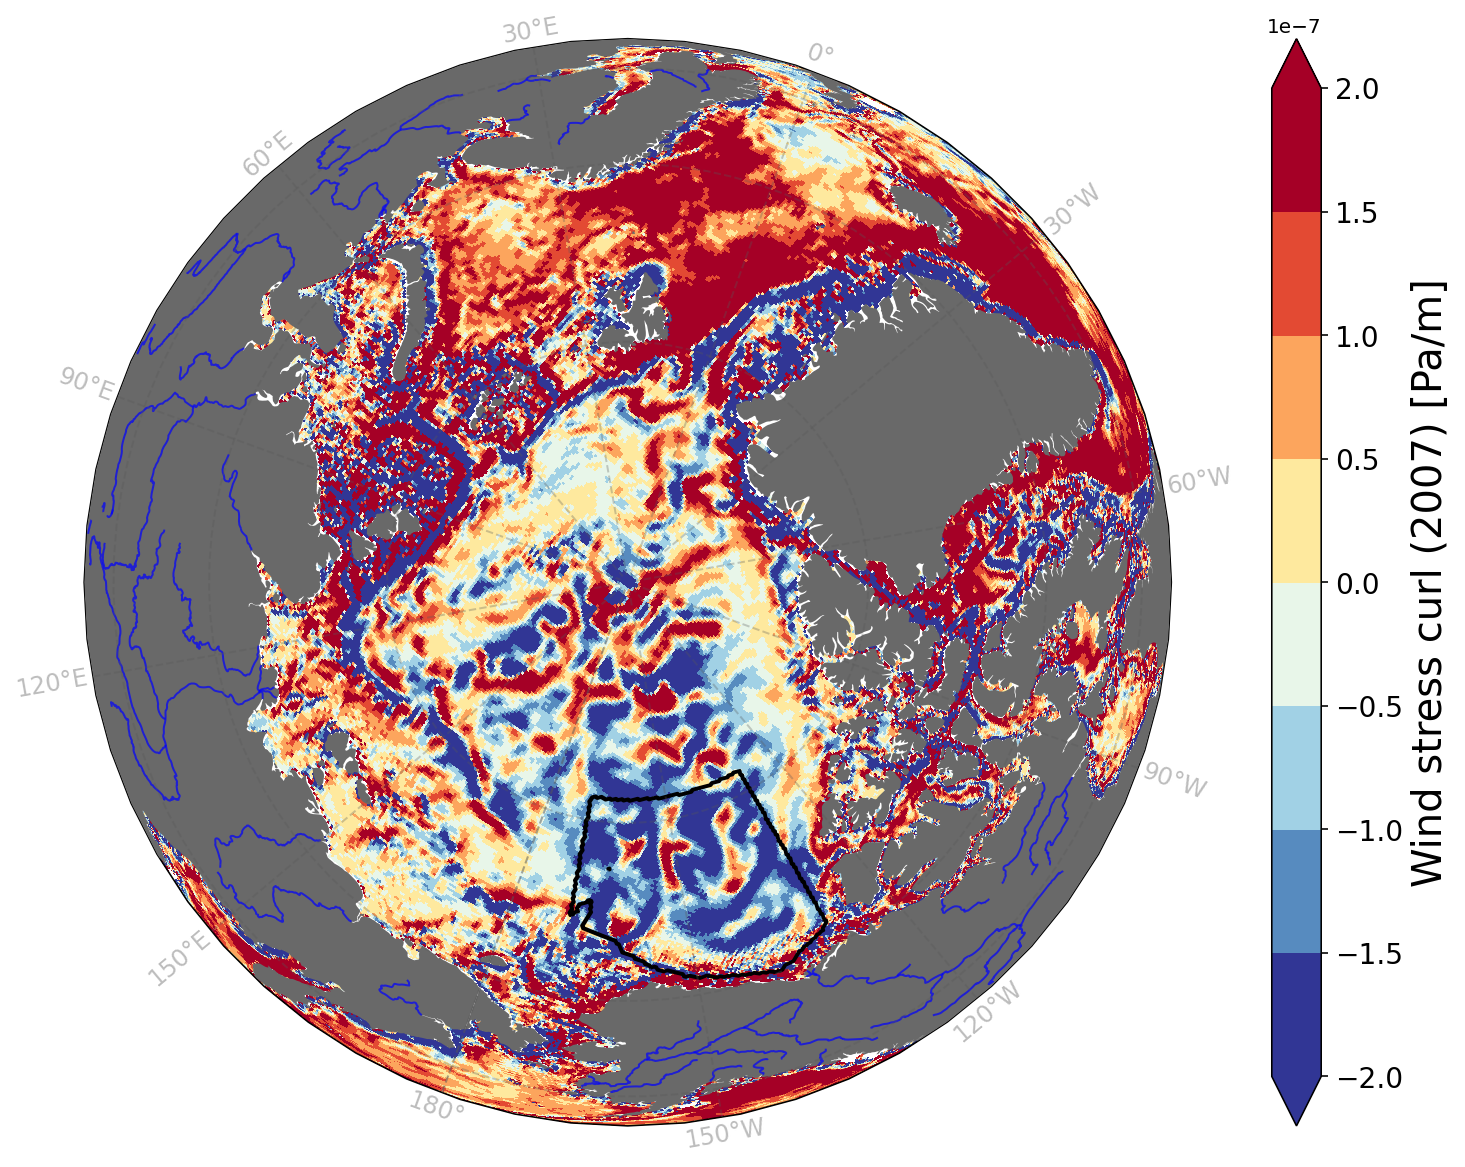

In [61]:
year = "2007"
curlGAIyear = curlGAI.sel(time_counter=year).squeeze()

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# tlabel=" SSH trend of GREENLAND (mm/yr) over "+y1+"-"+y2
# namo  ="SSH_trendGAIAI_"+y1+"-"+y2+".png"
namo  ="wind_stress_curl_cdftools_"+year+".png"

print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, curlGAIyear,shading='flat',cmap = mycm,transform=trdata, norm=norm)
ax.contour(nav_lon,nav_lat,maskBG,1,colors="k",transform=trdata)

cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Wind stress curl ("+year+") [Pa/m]", fontsize=20)

# cs2  = plt.pcolormesh(nav_lon, nav_lat, m2plt, shading='flat',transform=trdata) 
#========= coastlines and gridlines
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
clr2 = ax.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
gl.xlabel_style = label_style; gl.ylabel_style = label_style


# #============= BATHYMETRY
# bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
# color_levels= ['k','navy','mediumblue','slateblue']
# # west
# Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
# # east
# Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# plt.title(tlabel,fontsize=24)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)
# plt.clf()

# Analyse du wind stress curl de Gr+riv, Gr, et riv

In [63]:
curlall = curlGAI -curlS
curlGr = curlGAI -curlAI
curlRiv = curlAI -curlS

## cartes sur 2005-2018

In [64]:
y1= "2005"
y2= "2018"

curlallmean = curlall.sel(time_counter=slice(y1,y2)).mean('time_counter')
curlGrmean = curlGr.sel(time_counter=slice(y1,y2)).mean('time_counter')
curlRivmean = curlRiv.sel(time_counter=slice(y1,y2)).mean('time_counter')

wind_stress_curl_cdftools_2005-2018Riv.png


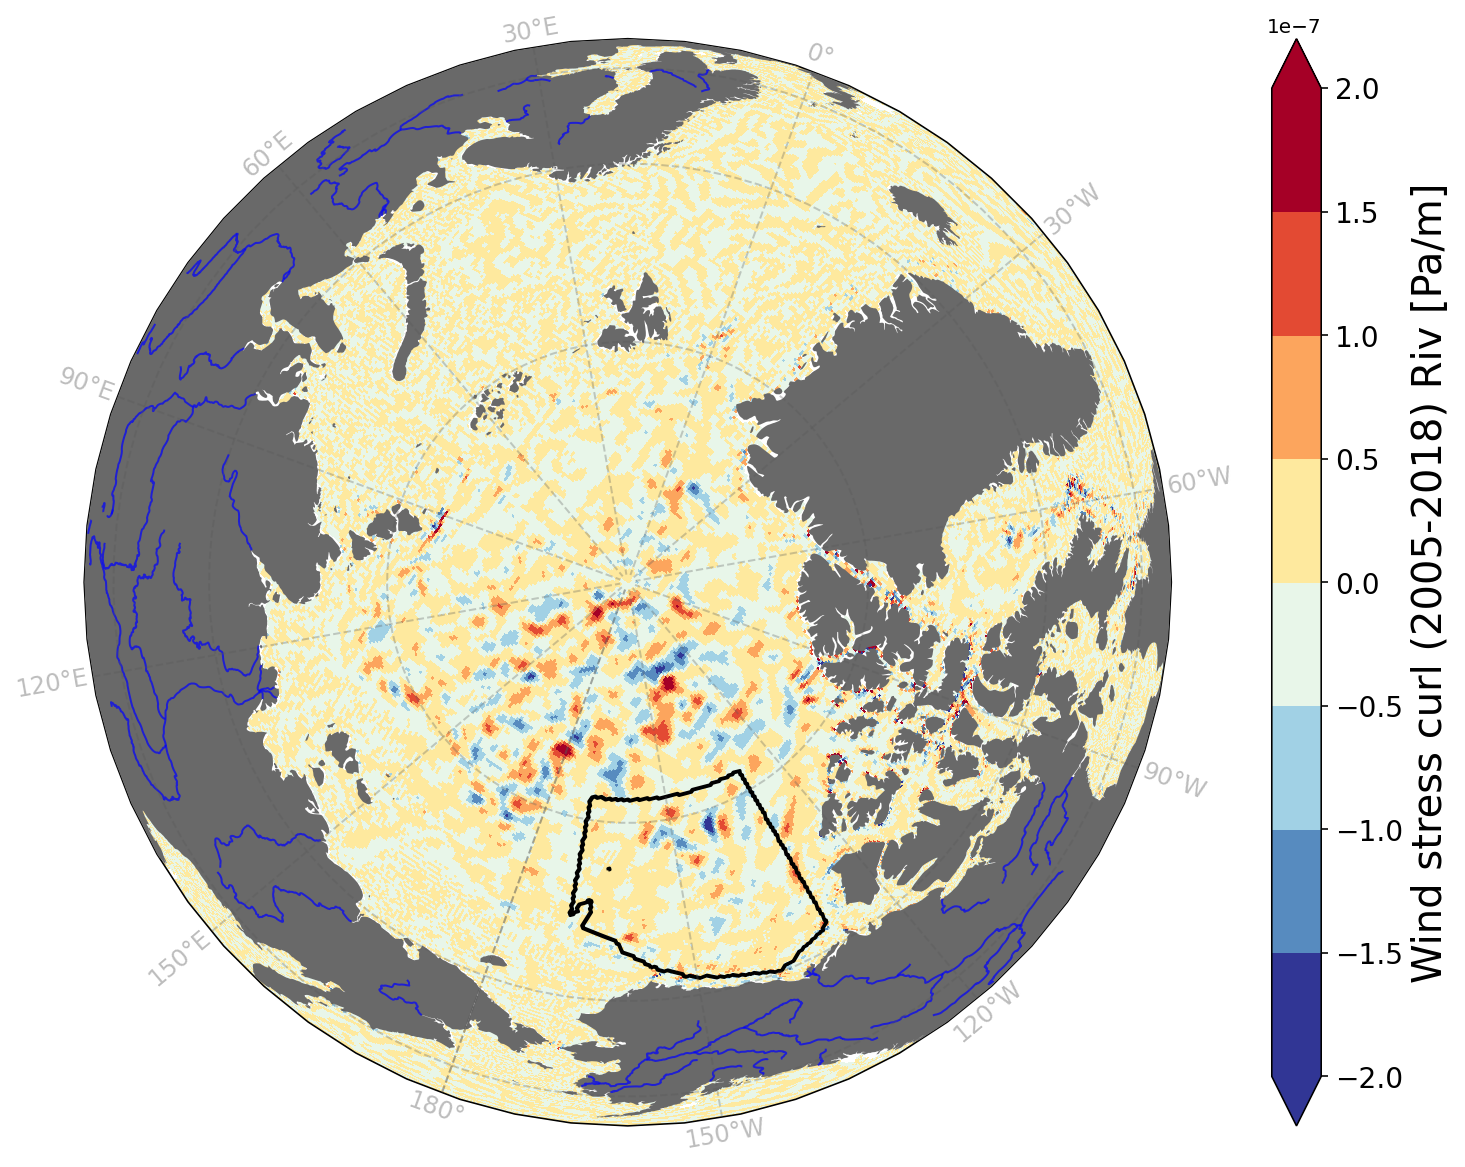

In [68]:

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

# tlabel=" SSH trend of GREENLAND (mm/yr) over "+y1+"-"+y2
# namo  ="SSH_trendGAIAI_"+y1+"-"+y2+".png"
namo  ="wind_stress_curl_cdftools_"+y1+"-"+y2+"Riv.png"

print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, curlRivmean,shading='flat',cmap = mycm,transform=trdata, norm=norm)
ax.contour(nav_lon,nav_lat,maskBG,1,colors="k",transform=trdata)

cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Wind stress curl ("+y1+"-"+y2+") Riv [Pa/m]", fontsize=20)

# cs2  = plt.pcolormesh(nav_lon, nav_lat, m2plt, shading='flat',transform=trdata) 
#========= coastlines and gridlines
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
clr2 = ax.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
gl.xlabel_style = label_style; gl.ylabel_style = label_style


# #============= BATHYMETRY
# bathy_levels = [200,1000,2000,4000] # We will apply a Gaussian filter to smooth the data. 
# color_levels= ['k','navy','mediumblue','slateblue']
# # west
# Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)
# # east
# Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0), bathy_levels,colors=color_levels,linewidths=0.7,linestyles='solid',transform=trdata)

# plt.title(tlabel,fontsize=24)
plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)
# plt.clf()

## cartes de tendances des différences sur 2005-2018

In [157]:
%%time
y1= "2005"
y2= "2018"
# calculate the trend on yearly data in mm/yr
trcoeffcurlall =  curlall.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().polyfit(dim='year',deg=1).polyfit_coefficients.isel(degree=0).compute()
trcoeffcurlGr  =   curlGr.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().polyfit(dim='year',deg=1).polyfit_coefficients.isel(degree=0).compute()
trcoeffcurlRiv =  curlRiv.sel(time_counter=slice(y1,y2)).groupby('time_counter.year').mean().polyfit(dim='year',deg=1).polyfit_coefficients.isel(degree=0).compute()

CPU times: user 23.1 s, sys: 1.41 s, total: 24.5 s
Wall time: 1min 43s


In [158]:
print((trcoeffcurlall.where(maskBG,drop=True)* WeightboxBG).sum(('x','y')).values)
print((trcoeffcurlGr.where(maskBG,drop=True)* WeightboxBG).sum(('x','y')).values)
print((trcoeffcurlRiv.where(maskBG,drop=True)* WeightboxBG).sum(('x','y')).values)

-2.9862664377254886e-11
4.889971678777737e-10
-5.188598322550284e-10


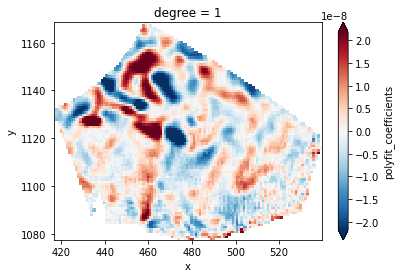

In [159]:
trcoeffcurlall.where(maskBG,drop=True).plot(robust=True)

In [163]:
lmin = -2e-8
incr = 2e-9
lmax = lmin*(-1)+incr
# define the bins and normalize
bounds = np.arange(lmin,lmax,incr)
norm = mcolors.BoundaryNorm(bounds, mycm.N)

bounds

array([-2.00000000e-08, -1.80000000e-08, -1.60000000e-08, -1.40000000e-08,
       -1.20000000e-08, -1.00000000e-08, -8.00000000e-09, -6.00000000e-09,
       -4.00000000e-09, -2.00000000e-09,  1.32348898e-23,  2.00000000e-09,
        4.00000000e-09,  6.00000000e-09,  8.00000000e-09,  1.00000000e-08,
        1.20000000e-08,  1.40000000e-08,  1.60000000e-08,  1.80000000e-08,
        2.00000000e-08])

wind_stress_curl_trend_cdftools_2005-2018all.png


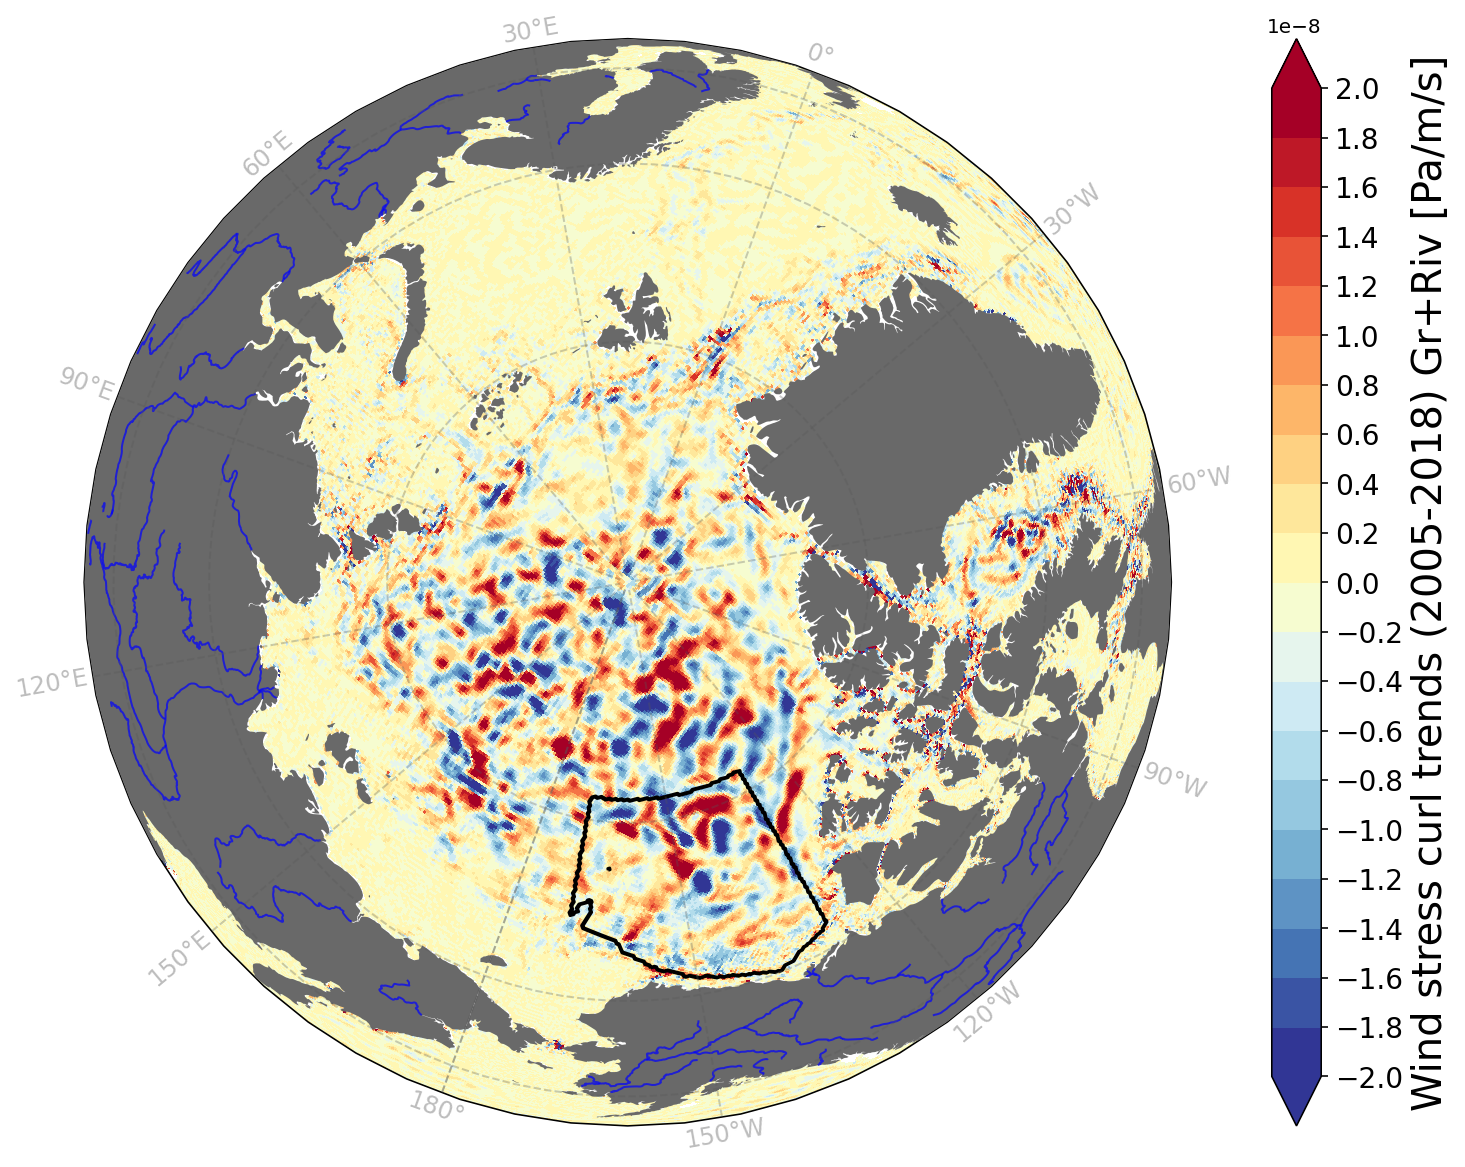

In [166]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
# tlabel=" SSH trend of GREENLAND (mm/yr) over "+y1+"-"+y2
namo  ="wind_stress_curl_trend_cdftools_"+y1+"-"+y2+"all.png"
# namo  ="wind_stress_curl_trend_cdftools_"+y1+"-"+y2+"Gr.png"
# namo  ="wind_stress_curl_trend_cdftools_"+y1+"-"+y2+"Riv.png"

print(namo)
#===========================================
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)

trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

#========= PLOT DATA
cs  = plt.pcolormesh(nav_lon, nav_lat, trcoeffcurlall,shading='flat',cmap = mycm,transform=trdata, norm=norm)
ax.contour(nav_lon,nav_lat,maskBG,1,colors="k",transform=trdata)

cbar = fig.colorbar(cs,extend='both', ticks=bounds)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Wind stress curl trends ("+y1+"-"+y2+") Gr+Riv [Pa/m/s]", fontsize=20)
# cbar.set_label(r"Wind stress curl trends ("+y1+"-"+y2+") Gr [Pa/m/s]", fontsize=20)
# cbar.set_label(r"Wind stress curl trends ("+y1+"-"+y2+") Riv [Pa/m/s]", fontsize=20)

# cs2  = plt.pcolormesh(nav_lon, nav_lat, m2plt, shading='flat',transform=trdata) 
#========= coastlines and gridlines
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',scale='50m',facecolor='none',edgecolor='b')
clr2 = ax.add_feature(rivers,alpha=0.7,facecolor='none',edgecolor='blue',zorder=6)
cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor="dimgrey",edgecolor= 'none',alpha=1,zorder=5)
gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
gl.xlabel_style = label_style; gl.ylabel_style = label_style


plt.show()
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
plt.close(fig)
